# Node classification with Node2Vec


In [1]:
# install StellarGraph if running on Google Colab

!pip install -q stellargraph[demos]==1.2.1 --ignore-requires-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph #feel free to use any other library of your choice
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [3]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


node2vec:

In [4]:
# walks = get random walks using BiasedRandomWalk
#experiment with the hyperparamenters 


walks = BiasedRandomWalk(G).run(
    nodes=list(G.nodes()),  
    length=80, 
    n=8,  
    p=0.7,  
    q=1.5,)  

print(len(walks))


19880


In [5]:
# from gensim.models import Word2Vec

# str_walks = [[str(n) for n in walk] for walk in walks]
# model = Word2Vec(str_walks, ) #check which parameter are important

from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, window=3, min_count=0, sg=1, workers=3)


In [6]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv["19231"].shape

(100,)

visualize

In [7]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [8]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

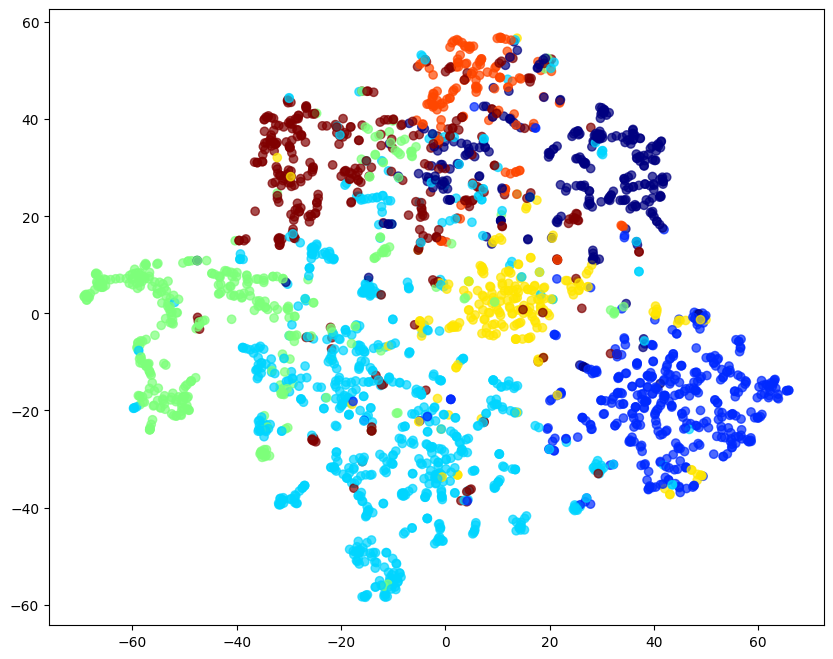

In [9]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

CORA classification

In [17]:
#X = None
#y = None
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = node_embeddings
y = np.array(node_targets)
#split the data. use 140 examples in train set 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=140)


#clf = classifier, use kfold cross validation 
clf = svm.SVC(kernel='linear', C= 4)
#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)

#get accuracy, classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of node2vec:", accuracy)

#-----------------------------------------------------------------------------------------------------------------------------------------------


from gensim.models import Word2Vec

X = G.node_features()
y = np.array(node_targets)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=140)

#clf = classifier, use kfold cross validation 
clf = svm.SVC(kernel='linear', C= 4)
#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)

#get accuracy, classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of node2vec:", accuracy)


#-----------------------------------------------------------------------------------------------------------------------------------------------

X = np.concatenate((G.node_features(), node_embeddings), axis=1)
y = np.array(node_targets)
#split the data. use 140 examples in train set 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=140)


#clf = classifier, use kfold cross validation 
clf = svm.SVC(kernel='linear', C= 4)
#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test)
y_pred = clf.predict(X_test)

#get accuracy, classification report
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of combined only:", accuracy)



Accuracy of node2vec: 0.6473347547974414
Accuracy of node2vec: 0.2230277185501066
Accuracy of combined only: 0.664818763326226
